In [1]:
#Importing relevant packages and King county data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools
from numbers import Number
from scipy import stats
import statsmodels.api as sm
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from sklearn.dummy import DummyRegressor
%matplotlib inline


df = pd.read_csv("data/kc_house_data.csv",parse_dates=['date'], index_col=0)

In [2]:
#Dropping columns that were suggested not to use, except date and zipcode
df.drop([ 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'waterfront'], 
        axis=1, inplace=True)

#Creating price per square foot column
df['price_sqft'] = df['price'] / df['sqft_living']

#dropping all outliers in price column, this increased our third models Rscore from .88 to .90
df = df[(np.abs(stats.zscore(df['price'])) < 3)]

In [3]:
#Creating map for zipcodes
zip_map = {
    98001:'Suburbs', 98002:'Suburbs', 98003:'Suburbs', 98004:'Suburbs', 98005:'Suburbs',
    98006:'Suburbs', 98007:'Suburbs',98008:'Suburbs', 98010:'Rural', 98011:'Suburbs', 
    98014:'Rural', 98019:'Rural', 98022:'Rural', 98023:'Suburbs', 98024:'Rural', 
    98027:'Rural', 98028:'Suburbs', 98029:'Suburbs', 98030:'Suburbs', 98031:'Suburbs',
    98032:'Suburbs', 98033:'Suburbs', 98034:'Suburbs', 98038:'Rural', 98039:'Suburbs',
    98040:'Suburbs', 98042:'Rural', 98045:'Rural', 98052:'Suburbs', 98053:'Rural',
    98055:'Suburbs', 98056:'Suburbs', 98058:'Suburbs', 98059:'Suburbs', 98065:'Rural',
    98070:'Suburbs', 98072:'Suburbs', 98074:'Suburbs', 98075:'Suburbs', 98077:'Rural',
    98092:'Suburbs', 98102:'Seattle', 98103:'Seattle', 98105:'Seattle', 98106:'Seattle',
    98107:'Seattle', 98108:'Seattle', 98109:'Seattle', 98112:'Seattle', 98115:'Seattle', 
    98116:'Seattle', 98117:'Seattle', 98118:'Seattle', 98119:'Seattle', 98122:'Seattle',
    98125:'Seattle', 98126:'Seattle', 98133:'Seattle', 98136:'Seattle', 98144:'Seattle', 
    98146:'Seattle', 98148:'Seattle', 98155:'Seattle', 98166:'Seattle', 98168:'Seattle',
    98177:'Seattle', 98178:'Seattle', 98188:'Seattle', 98198:'Seattle', 98199:'Seattle'
    }

#creating a map for condition since there are low values of Poor and Fair compared to the other categorical variables
condition_map = {
                 'Poor': 0,
                 'Fair': 1,
                 'Average': 2,
                 'Good': 3,
                 'Very Good': 4
                }

#mapping grade map
grade_map = {
             '3 Poor': 3,
             '4 Low': 4,
             '5 Fair': 5,
             '6 Low Average': 6,
             '7 Average': 7,
             '8 Good': 8,
             '9 Better': 9,
             '10 Very Good': 10,
             '11 Excellent': 11,
             '12 Luxury': 12,
             '13 Mansion': 13
            }

# Adding maps to dataframe & dropping columns that were mapped
df['zones'] = df['zipcode'].map(zip_map)
df.drop('zipcode', axis=1, inplace=True);
df['cond_num'] = df['condition'].map(condition_map)
df.drop('condition', axis = 1, inplace=True);
df['grade_num'] = df['grade'].map(grade_map)
df.drop('grade', axis = 1, inplace=True);

Sorted zipcodes with following sources
- website =  https://www.unitedstateszipcodes.org/wa/ 
- map = https://aqua.kingcounty.gov/gis/web/VMC/boundaries/zipcodes/zipcodes.pdf

# Things to do

- create graphs for models 
- make your price per sqfoot over zones graph pretty

In [4]:
#Dummymodel creation and evaluation
dummymodel = DummyRegressor(strategy = "mean")
X = df.drop(columns ='price', axis = 1)
y = df['price']
dummymodel = dummymodel.fit(X, y)

dummymodel.predict(X)
dummymodel.predict(y)
dummymodel.score(X, y)

0.0

# Ordinal & One Hot Encoder
Can do OrdinalEncoder directly on condition and grade but might be better to bin them since there are a fair amount of unique values for both which could cause multicollinearlity.

For condition:

- Poor
- Fair
- Average
- Good
- Very Good


For grade:

- 7 Average
- 8 Good
- 9 Better
- 6 Low Average
- 10 Very Good
- 11 Excellent
- 5 Fair
- 12 Luxury
- 4 Low
- 13 Mansion
- 3 Poor

Zipcode:
- Rural
- Suburbs
- Seattle

In [5]:
#defining X & y
X = df.drop(columns='price', axis=1)
y = df['price']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#creating a train df and test df
train_kch = pd.concat([X_train, y_train], axis=1)
test_kch = pd.concat([X_test, y_test], axis=1)

In [6]:
#Creating variables storing our Ordinal & One Hot Encoding columns
train_kch_cat = train_kch[['cond_num', 'grade_num']]
train_kch_zones = train_kch[['zones']]
test_kch_cat = test_kch[['cond_num', 'grade_num']]
test_kch_zones = test_kch[['zones']]

#Initializing Ordinal and One Hot
ore = OrdinalEncoder()
ore.fit(train_kch_cat)
ohe = OneHotEncoder(sparse=False)
ohe.fit(train_kch_zones)


#Applying Ordinal and One Hot to our Train and Test
ohe_transform = ohe.transform(train_kch_zones)
zones_encoded = pd.DataFrame(ohe.fit_transform(train_kch_zones),
                            index=train_kch_zones.index)


ohe_test_transform = ohe.transform(test_kch_zones)
zones_encoded_test = pd.DataFrame(ohe.fit_transform(test_kch_zones),
                                 index=test_kch_zones.index)

ore_transform = ore.transform(train_kch_cat)
cat_encoded = pd.DataFrame(ore_transform, columns = ['cond_num_cat','grade_num_cat'], 
                          index=train_kch_cat.index)

ore_test_transform = ore.transform(test_kch_cat)
cat_encoded_test = pd.DataFrame(ore_test_transform, columns = ['cond_num_cat','grade_num_cat'], 
                          index=test_kch_cat.index)



# Standard Scaling

In [7]:
#standard scaling the numerical values dropping categorical and target 
#training data
X_train_kch_nums = train_kch.drop(['cond_num', 'grade_num', 
                                   'zones','date', 'price'], axis=1)
y_train_kch = train_kch['price']

#testing data
X_test_kch_nums = test_kch.drop(['cond_num','grade_num', 
                                'zones','date', 'price'], axis=1)
y_test_kch = test_kch['price']

#Standardized Scaler - fit to training x
ss = StandardScaler().fit(X_train_kch_nums)



#training data - transform
X_train_scaled = pd.DataFrame(ss.transform(X_train_kch_nums), columns=X_train_kch_nums.columns, index=X_train_kch_nums.index)


#testing data - transform
X_test_scaled = pd.DataFrame(ss.transform(X_test_kch_nums), columns=X_test_kch_nums.columns, index=X_test_kch_nums.index)



In [8]:
#now can join the two separate variables - standardized and numerical
train_kch = pd.concat([X_train_scaled, cat_encoded, zones_encoded, y_train_kch],axis=1)

# Linear & Multilinear Regression

In [9]:
#checking correlations on price for modeling
price_corr = train_kch.corr()['price']
price_corr.abs().sort_values(ascending=False)[1:]

grade_num_cat    0.672041
sqft_living      0.664505
price_sqft       0.507379
bathrooms        0.492210
bedrooms         0.315109
floors           0.278772
sqft_lot         0.090634
0                0.073551
yr_built         0.056489
2                0.049528
cond_num_cat     0.035689
1                0.004917
Name: price, dtype: float64

In [10]:
#Initializing LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_kch)

LinearRegression()

In [11]:
lr.score(X_train_scaled, y_train_kch)

0.903156750340451

In [12]:
#Here is our first model, just a simple linear regression between price and square feet
# I want to try and bring the R2 value up more
X_baseline = train_kch['sqft_living']

baseline_model = sm.OLS(y_train_kch, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

baseline_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                 1.340e+04
Date:                Thu, 15 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:56:56   Log-Likelihood:            -2.3042e+05
No. Observations:               16952   AIC:                         4.608e+05
Df Residuals:                   16950   BIC:                         4.609e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.057e+05   1487.042    340.075      0.000    5.03e+05    5.09e+05
sqft_living  1.722e+05   1487.042    115.770      0.000    1.69e+05    1.75e+05
==============================================================================
Omnibus:                     2849.918   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6150.114
Skew:                           0.992   Prob(JB):                         0.00
Kurtosis:                       5.184   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
#here is our second model where I try and add the 2nd highest correlated value to the model to see if I can bring R2 up
#It appears to not have worked
baseline_constant2 = train_kch[['sqft_living', 'bathrooms']]


baseline_model2 = sm.OLS(y_train_kch, sm.add_constant(baseline_constant2))
baseline_results2 = baseline_model2.fit()



In [14]:
#So here is our third model, where we made this after we added our Ordinal and One Hot encoder 
#as well as standized all the numaric values, this performs way better than our first 2 iterations with a R2 of .88
#I think I want to try and improve this with adding our catagorical data ie: grade, condition, and zone

baseline_model3 = sm.OLS(y_train_kch, sm.add_constant(X_train_scaled))
baseline_results3 = baseline_model3.fit()


In [15]:
baseline_constant4 = train_kch[['sqft_living', 'grade_num_cat']]

In [16]:
baseline_model4 = sm.OLS(y_train_kch, sm.add_constant(baseline_constant4))
baseline_results4 = baseline_model4.fit()

In [17]:
baseline_constant5 = train_kch[['sqft_living', 'grade_num_cat', 'price_sqft', 'bathrooms']]

In [18]:
baseline_model5 = sm.OLS(y_train_kch, sm.add_constant(baseline_constant5))
baseline_results5 = baseline_model5.fit()

In [19]:
baseline_constant6 = train_kch[['sqft_living', 'grade_num_cat', 'price_sqft']]

In [20]:
baseline_model6 = sm.OLS(y_train_kch, sm.add_constant(baseline_constant6))
baseline_results6 = baseline_model6.fit()

In [21]:
baseline_constant7 = pd.concat([train_kch[['sqft_living', 'grade_num_cat', 'price_sqft']], zones_encoded], axis=1)

In [32]:
train_kch.std()

bedrooms              1.000029
bathrooms             1.000029
sqft_living           1.000029
sqft_lot              1.000029
floors                1.000029
yr_built              1.000029
price_sqft            1.000029
cond_num_cat          0.647773
grade_num_cat         1.109146
0                     0.365887
1                     0.492787
2                     0.494433
price            259080.713047
dtype: float64

In [23]:
y_train_kch_1k = y_train_kch/1000

In [38]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,price_sqft,cond_num,grade_num
count,2.119100e+04,21191.000000,21191.000000,21191.000000,2.119100e+04,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000
mean,5.070103e+05,3.356095,2.087514,2032.486103,1.482673e+04,1.486858,1970.926525,259.373918,2.408051,7.605304
std,2.594622e+05,0.917527,0.736021,836.738586,4.040095e+04,0.538297,29.285262,104.013189,0.648903,1.108906
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1900.000000,87.588235,0.000000,3.000000
25%,3.200000e+05,3.000000,1.500000,1410.000000,5.005500e+03,1.000000,1951.000000,181.149886,2.000000,7.000000
50%,4.470000e+05,3.000000,2.250000,1890.000000,7.560000e+03,1.000000,1975.000000,242.553191,2.000000,7.000000
75%,6.276500e+05,4.000000,2.500000,2500.000000,1.049050e+04,2.000000,1996.000000,313.202602,3.000000,8.000000
max,1.640000e+06,33.000000,7.500000,7480.000000,1.651359e+06,3.500000,2015.000000,810.138889,4.000000,12.000000


In [24]:
baseline_model7 = sm.OLS(y_train_kch_1k, sm.add_constant(baseline_constant7))
baseline_results7 = baseline_model7.fit()

baseline_results7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 3.274e+04
Date:                Thu, 15 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:56:56   Log-Likelihood:                -98199.
No. Observations:               16952   AIC:                         1.964e+05
Df Residuals:                   16946   BIC:                         1.965e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           299.2034      3.051     98.058      0.000     293.223     305.184
sqft_living     194.2983      0.978    198.578      0.000     192.380     196.216
grade_num_cat    22.5401      0.870     25.920      0.000      20.836      24.245
price_sqft      174.2001      0.699    249.090      0.000     172.829     175.571
0                88.3355      1.605     55.030      0.000      85.189      91.482
1               104.7903      1.264     82.926      0.000     102.313     107.267
2               106.0777      1.387     76.471      0.000     103.359     108.797
==============================================================================
Omnibus:                     3071.289   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31319.499
Skew:                          -0.571   Prob(JB):                         0.00
Kurtosis:                       9.560   Cond. No.                     1.07e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.54e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Evaluate Performance

In [25]:
y_hat= lr.predict(X_train_scaled)
y_hat

array([493072.39525253, 919869.49697746, 232140.27746405, ...,
       227672.84455938, 789521.84383224, 557686.74933203])

In [26]:
resid=(y_train_kch - y_hat)
resid

id
1189000910     23927.604747
1423089055    -74869.496977
6083000050      2859.722536
7390400069    -84399.753924
9468200100   -127307.876261
                  ...      
7806210400    -12285.091006
3211200140     14691.273386
2475200080     40327.155441
7504110030     -4521.843832
952001495      30313.250668
Name: price, Length: 16952, dtype: float64

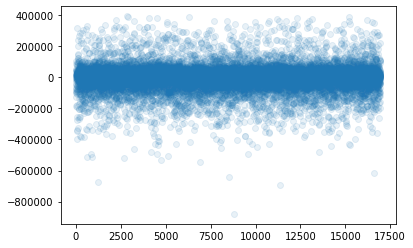

In [27]:
fig, ax  =plt.subplots()
ax.scatter(x=range(y_hat.shape[0]), y=resid, alpha=.1);

# Visualizations 

- mean price per square foot in each zone for a average house

In [28]:
sns.set(style='darkgrid')

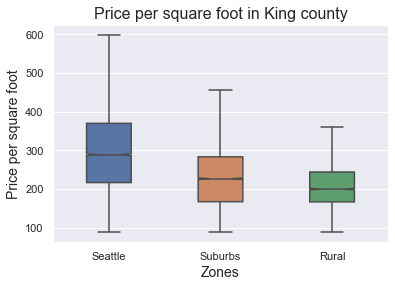

In [29]:

boxplot = sns.boxplot(x=df['zones'], y=df['price_sqft'], linewidth=1.5,notch=True,showfliers=False,
                      width =.4, order=['Seattle','Suburbs','Rural']);
boxplot.axes.set_title('Price per square foot in King county', fontsize=16)
boxplot.set_xlabel('Zones', fontsize=14)
boxplot.set_ylabel('Price per square foot', fontsize=14)
plt.show()

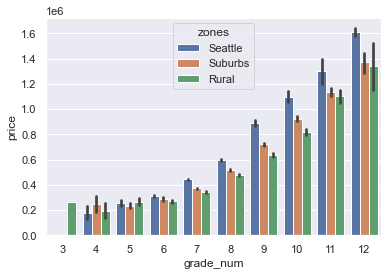

In [30]:
bargraph = sns.barplot(data=df, x='grade_num', y='price', hue='zones')

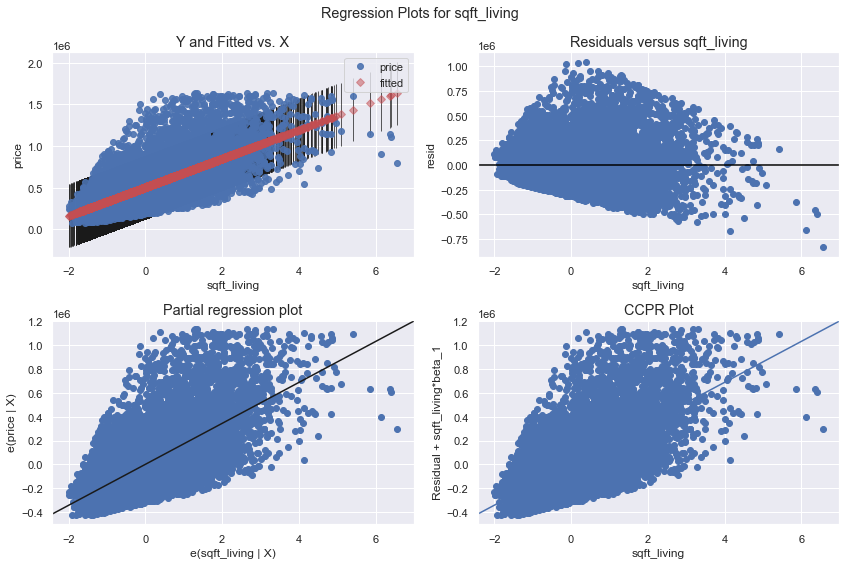

In [31]:
sm.graphics.plot_regress_exog(baseline_results, 'sqft_living', fig=plt.figure(figsize=(12, 8)));